In [1]:
# LAMBDA PYTHON IMPORT
import os
import sys
sys.path.insert(0, os.path.abspath('./code/'))

# PYSPARK IMPORT
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()

# CUSTOM IMPORT
import entryPoint

In [2]:
# IMPORT DATASET
path = "./data/subventions-accordees-et-refusees.csv"
df = spark.read.format('csv').options(header=True, inferSchema=True, sep =';').load(path)

newColumns = ['Num', 'Annee', 'Collectivite', 'Benificiaire', 'Siret', 'Objet', 'Montant', 'Direction', 'Nature', 'Secteur']
df = df.toDF(*newColumns)

In [3]:
# Récupération des secteurs

secteurs = entryPoint.getAllSecteur(df)

for secteur in secteurs:
    print(secteur)

Aides aux associations
Architecture & urbanisme
Communication & média
Culture & Arts
Défense des droits et des intérêts
Déplacements et transports
Economie
Education & formation
Emploi
Environnement & écologie
Humanitaire
Idée & opinion
Loisirs
Mémoire
Précarité & Exclusion
Relations internationales
Santé
Social
Sport
Technique & Recherche
Tourisme
Vie et animation locale


In [4]:
# Récupérer uniquement un `Secteur` spécifique

entryPoint.selectSecteur(df, 'Vie et animation locale').take(10)

[Row(Num='2019_05884', Annee=2019, Collectivite='Ville de Paris', Benificiaire='129 H PRODUCTIONS', Siret='44326922000036', Objet='Le Grand Slam des Amandiers', Montant='2500', Direction='DAC', Nature='Projet', Secteur='Culture & Arts;Education & formation;Vie et animation locale'),
 Row(Num='2019_06441', Annee=2019, Collectivite='Ville de Paris', Benificiaire='13 POUR TOUS', Siret='48905531900029', Objet='Pause toi là', Montant='3000', Direction='DJS', Nature='Projet', Secteur='Loisirs;Social;Vie et animation locale'),
 Row(Num='2019_02145', Annee=2019, Collectivite='Ville de Paris', Benificiaire='3 S : SEJOUR SPORTIF SOLIDAIRE', Siret='81147565600013', Objet='Transport, voirie, déplacements et espace public', Montant='0', Direction='DVD', Nature='Non précisée', Secteur='Environnement & écologie;Sport;Vie et animation locale'),
 Row(Num='2019_07417', Annee=2019, Collectivite='Ville de Paris', Benificiaire="ACCUEIL GOUTTE D'OR", Siret='40864600800057', Objet="Atelier Parents d'enfants 

Renseignez votre année : (2013 - 2020) 2019


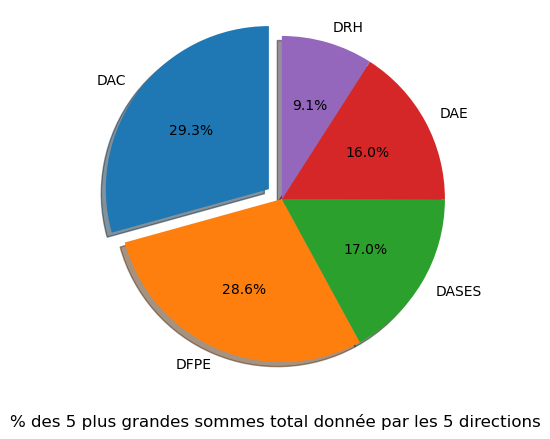

In [5]:
# Permet d'obtenir le montant total des 5 directions qui subventionnent le plus les associations.

entryPoint.getAmountSubventionByDirection(df)

Renseignez votre année : (2013 - 2020) 2019


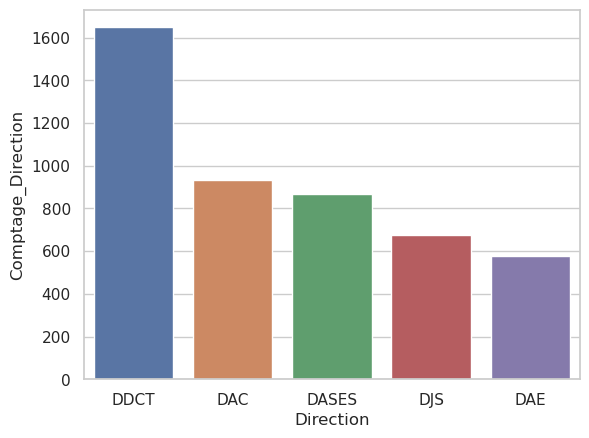

In [6]:
# Permet d'obtenir le nombre total de subvention accordées par les directions.

entryPoint.getCountAcceptedSubventionByDirection(df)

In [7]:
#Combien il y a eu de Secteur par année

entryPoint.getSecteurParAnnee(df)

+-----+--------------+
|Annee|count(Secteur)|
+-----+--------------+
| 2013|          8157|
| 2014|          7643|
| 2015|          8210|
| 2016|          8814|
| 2017|          8635|
| 2018|          8394|
| 2019|          9554|
| 2020|         10098|
+-----+--------------+



In [8]:
#Quel est le montant accordé par Secteur par année

entryPoint.montantSecteurAnnee(df)

+-----+--------------------+------------+
|Annee|             secteur|sum(Montant)|
+-----+--------------------+------------+
| 2019|Aides aux associa...|    539028.0|
| 2019|Précarité & Exclu...|         0.0|
| 2017|Education & forma...|     33500.0|
| 2018|Education & forma...|    135682.0|
| 2014|Humanitaire;Santé...|   2900547.0|
| 2017|Défense des droit...|         0.0|
| 2017|Education & forma...|     15311.0|
| 2013|Défense des droit...|     93406.0|
| 2015|Défense des droit...|    101800.0|
| 2015|Culture & Arts;Ed...|     32518.0|
| 2018|Aides aux associa...|      4500.0|
| 2017|Communication & m...|      2000.0|
| 2016|Défense des droit...|    145802.0|
| 2015|Culture & Arts;Dé...|     34800.0|
| 2016|Communication & m...|         0.0|
| 2019|Communication & m...|     20000.0|
| 2018|Culture & Arts;So...|   1883012.0|
| 2017|Culture & Arts;Re...|    849170.0|
| 2014|Culture & Arts;Ed...|     47428.0|
| 2015|Aides aux associa...|    514463.0|
+-----+--------------------+------

In [9]:
def myFlatMap(words, amount):
    '''
        Transforme en lowercase, supprime les doublons, retourne (mot, montant)
    '''
    words = map(lambda word: word.lower(), words)
    words = set(words)
    words = map(lambda word: (word, amount), words)
    
    return words

def myReducer(accumulator, currentValue):
    '''
        Convertie et additionne les deux valeurs
    '''
    try:
        accumulator = int(accumulator)
    except:
        accumulator = 0
    try:
        currentValue = int(currentValue)
    except:
        currentValue = 0
    
    return accumulator + currentValue
        

def getMontantByWord(df):
    '''
        Récupérer le `Montant` en fonction des mots clée présent dans `Objet`
    '''
    bannedWords = ('de', 'et', 'la', '-', 'du', 'des', 'pour', 'en', 'dans', 'le', 'à', 'les', 'au', 'aux', 'sur', \
                'd\'un', 'd\'une', ':', 'par', 'avec', '')

    dfObjectWordMontant = df.select("Objet", "Montant")
    return dfObjectWordMontant.rdd.map(lambda row: [str(row[0]).split(' '), row[1]]) \
            .flatMap(lambda row: myFlatMap(row[0], row[1])) \
            .reduceByKey(lambda accumulator, currentValue : myReducer(accumulator, currentValue)) \
            .toDF() \
            .where(f"_1 NOT IN {bannedWords}") \
            .sort(desc('_2'))

In [10]:
# Récupérer le `Montant` en fonction des mots clée présent dans `Objet`

getMontantByWord(df).show(20)

+--------------+---------+
|            _1|       _2|
+--------------+---------+
|fonctionnement|831997053|
|    subvention|427733649|
|         paris|201038764|
|       acompte|160503921|
|          2020|133225654|
|           dac|126902423|
|        crèche|125569114|
|           rue|119776886|
|          2015|117204096|
|         ville|117108540|
|          2018|115050688|
|          2016| 96941959|
|          2014| 93981912|
|          2013| 93206113|
|          2019| 86322635|
|        budget| 72057218|
|          2017| 67250135|
|   d'équilibre| 60490500|
|           dfa| 55876852|
|régularisation| 52832309|
+--------------+---------+
only showing top 20 rows



In [11]:
# Montant des subventions accordées par bénéficiaires

entryPoint.subvention_by_actor(df)

+--------------------+------------+
|        Benificiaire|sum(Montant)|
+--------------------+------------+
|             BAHAMAS|       11800|
|     VERGERS URBAINS|      182050|
|       TOUSLESMUSEES|           0|
|COORDINATION EAU-...|       81200|
|             TECHNO+|      157055|
|       SORS DE TERRE|       14000|
|    AVEC NOS PROCHES|       68000|
|ETHNOLOGUES EN HERBE|       79100|
|           IMMANENCE|      301000|
|    MOUVEMENT DU NID|       78000|
|ASSOCIATION DES C...|       17700|
|COMITÉ DES FÊTES ...|      123000|
|CINEMAS INDEPENDA...|      655750|
|FÉDÉRATION NATION...|       84000|
|SECTION DE GYMNAS...|        3700|
|     A.B.C. BOUVINES|       44485|
|RÉSEAU VIVACITÉS ...|           0|
|SHOTOKAN KARATE D...|         950|
|            L'ASSAUT|           0|
|ASSOCIATION DO JE...|       21650|
+--------------------+------------+
only showing top 20 rows



In [12]:
# Demandes d'argent les plus importantes, tous bénéficiaires confondus, toutes années confondues

entryPoint.subvention_by_actor_ordered(df)

+--------------------+--------+
|        Benificiaire| Montant|
+--------------------+--------+
|THEATRE MUSICAL D...|17446000|
|THEATRE MUSICAL D...|17246000|
|THEATRE MUSICAL D...|16246000|
|ASSOCIATION D'ACT...|12377000|
|ASSOCIATION D'ACT...|12377000|
|ASSOCIATION D'ACT...|11566305|
|ASSOCIATION DU TH...|10900000|
|ASSOCIATION DU TH...|10750000|
|ASSOCIATION DU TH...|10650000|
|ASSOCIATION D'ACT...|10348540|
|ASSOCIATION D'ACT...|10319000|
|ASSOCIATION D'ACT...|10317114|
|ASSOCIATION D'ACT...|10270100|
|ASSOCIATION D'ACT...|10196100|
|THEATRE MUSICAL D...|10150000|
|THEATRE MUSICAL D...| 8500000|
|PHILHARMONIE DE P...| 8400000|
|THEATRE MUSICAL D...| 8123000|
|PHILHARMONIE DE P...| 8058579|
|ASSOCIATION POUR ...| 8039538|
+--------------------+--------+
only showing top 20 rows



In [13]:
# Nombre de demandes par année, par bénéficiaire

entryPoint.requests_by_actors_by_year(df)

+--------------------+-----+-------------------+
|        Benificiaire|Annee|count(Benificiaire)|
+--------------------+-----+-------------------+
|            (S) VRAI| 2020|                  1|
|         *DUUU RADIO| 2020|                  2|
|    1 TOUCHE 2 STYLE| 2020|                  1|
|              1 WATT| 2020|                  1|
|1000 VISAGES PROD...| 2020|                  2|
|1001 FONTAINES PO...| 2020|                  1|
|    11EME EVENEMENTS| 2020|                  4|
|    12 BARS EN SCENE| 2020|                  1|
|         123 SOLEILS| 2020|                  1|
|   129 H PRODUCTIONS| 2020|                  5|
|           13 AVENIR| 2020|                  1|
|13 EN VUE TREIZE ...| 2020|                  1|
|        13 POUR TOUS| 2020|                 13|
|13ONZE15 : FRATER...| 2020|                  2|
|         16.51 OUEST| 2020|                  2|
|        24 AOÛT 1944| 2020|                  1|
|        3 DIMENSIONS| 2020|                  1|
|3 S : SEJOUR SPOR..

In [14]:
# Nombre total de bénéficiaires

entryPoint.total_of_actors(df)

+----------------------------+
|count(DISTINCT Benificiaire)|
+----------------------------+
|                       10660|
+----------------------------+



In [15]:
# Bénéficiaires ayant fait le plus de demandes, par année

entryPoint.max_requests_by_actors_by_year(df)

+--------------------+-----+-------------------+
|        Benificiaire|Annee|count(Benificiaire)|
+--------------------+-----+-------------------+
|           CRESCENDO| 2020|                 52|
|           CRESCENDO| 2019|                 57|
|           CRESCENDO| 2018|                 49|
|           ENTR AIDE| 2017|                 50|
|           ESPACE 19| 2016|                 51|
|   ACTIONS JEUNES AJ| 2015|                 43|
|          ART-EXPRIM| 2014|                115|
|CENTRE EPINETTES ...| 2013|                 49|
+--------------------+-----+-------------------+



In [16]:
# Bénéficiaire ayant touché le plus d'argent, par année

entryPoint.max_amount_by_actors_by_year(df)

+--------------------+-----+------------+
|        Benificiaire|Annee|sum(Montant)|
+--------------------+-----+------------+
|THEATRE MUSICAL D...| 2020|    16274000|
|THEATRE MUSICAL D...| 2019|    16500000|
|ASSOCIATION D'ACT...| 2018|    14701450|
|ASSOCIATION D'ACT...| 2017|    13289547|
|THEATRE MUSICAL D...| 2016|    15279000|
|PHILHARMONIE DE P...| 2015|    21658233|
|PHILHARMONIE DE P...| 2014|    18165000|
|THEATRE MUSICAL D...| 2013|    17746000|
+--------------------+-----+------------+



In [17]:
#Récupérer le nombre de Bénificiares par année.

entryPoint.nbrBenParAnnee(df)

+-----+-------------------+
|Annee|count(Benificiaire)|
+-----+-------------------+
| 2020|              10106|
| 2019|               9564|
| 2018|               8395|
| 2017|               8635|
| 2016|               8814|
| 2015|               8210|
| 2014|               7648|
| 2013|               8297|
+-----+-------------------+



+-----+-------------+
|Annee|Montant_total|
+-----+-------------+
| 2020| 2.95523457E8|
| 2019| 2.91282504E8|
| 2018| 2.71366258E8|
| 2017| 2.76239759E8|
| 2016| 2.75349227E8|
| 2015| 2.70815164E8|
| 2014| 2.58237727E8|
| 2013| 2.40467938E8|
+-----+-------------+



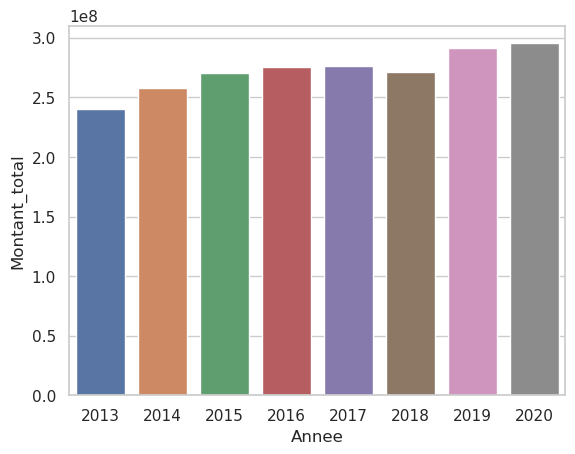

In [18]:
# Calculer le montant total accordé par année

entryPoint.montantAccordeParAnnee(df)

+-----+------------------+
|Annee|Nombre_de_demandes|
+-----+------------------+
| 2020|             10106|
| 2019|              9564|
| 2018|              8397|
| 2017|              8640|
| 2016|              8819|
| 2015|              8214|
| 2014|              7650|
| 2013|              8300|
+-----+------------------+



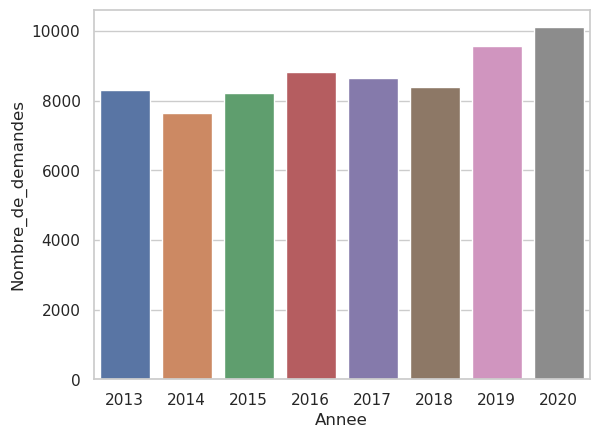

In [19]:
# Nombre de demande par année

entryPoint.nbrDemandeParAnnee(df)